In [1]:
# Basic Libraries
import sys
import time
import gc
import random
import copy 
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# PyTorch Libraries
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

# Data Handling and Image Processing
from torchvision import datasets, transforms

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from skimage.metrics import structural_similarity as ssim

# Style for Matplotlib
import scienceplots
plt.style.use('science')
plt.style.use(['no-latex'])

# Scientific Computing and Machine Learning
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.linalg import subspace_angles
from scipy.spatial.distance import cosine
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import pearsonr

# Custom Modules and Extensions
sys.path.append("../netrep/")
sys.path.append("../svcca/")
import cca_core
from netrep.metrics import LinearMetric
import networks as nets  # Contains RNNs
import net_helpers
import mpn_tasks
import helper
import mpn

import scienceplots
plt.style.use('science')
plt.style.use(['no-latex'])

# Memory Optimization
gc.collect()
torch.cuda.empty_cache()
torch.cuda.ipc_collect()

In [2]:
# 0 Red, 1 blue, 2 green, 3 purple, 4 orange, 5 teal, 6 gray, 7 pink, 8 yellow
c_vals = ['#e53e3e', '#3182ce', '#38a169', '#805ad5','#dd6b20', '#319795', '#718096', '#d53f8c', '#d69e2e',]
c_vals_l = ['#feb2b2', '#90cdf4', '#9ae6b4', '#d6bcfa', '#fbd38d', '#81e6d9', '#e2e8f0', '#fbb6ce', '#faf089',]
c_vals_d = ['#9b2c2c', '#2c5282', '#276749', '#553c9a', '#9c4221', '#285e61', '#2d3748', '#97266d', '#975a16',]
l_vals = ['solid', 'dashed', 'dotted', 'dashdot', '-', '--', '-.', ':', (0, (3, 1, 1, 1)), (0, (5, 10))]
markers_vals = ['o', 'v', '^', '<', '>', '1', '2', '3', '4', 's', 'p', '*', 'h', 'H', '+', 'x', 'D', 'd', '|', '_']
hyp_dict = {}

In [3]:
# Reload modules if changes have been made to them
from importlib import reload

reload(nets)
reload(net_helpers)

fixseed = False # randomize setting the seed may lead to not perfectly solved results
seed = random.randint(1,1000) if not fixseed else 8 # random set the seed to test robustness by default
print(f"Set seed {seed}")
np.random.seed(seed)
torch.manual_seed(seed)

hyp_dict['task_type'] = 'multitask' # int, NeuroGym, multitask
hyp_dict['mode_for_all'] = "random"
hyp_dict['ruleset'] = 'dmcgo' # low_dim, all, test

accept_rules = ('fdgo', 'fdanti', 'delaygo', 'delayanti', 'reactgo', 'reactanti', 
                'delaydm1', 'delaydm2', 'dmsgo', 'dmcgo', 'contextdelaydm1', 'contextdelaydm2', 'multidelaydm')


rules_dict = \
    {'all' : ['fdgo', 'reactgo', 'delaygo', 'fdanti', 'reactanti', 'delayanti',
              'dm1', 'dm2', 'contextdm1', 'contextdm2', 'multidm',
              'delaydm1', 'delaydm2', 'contextdelaydm1', 'contextdelaydm2', 'multidelaydm',
              'dmsgo', 'dmsnogo', 'dmcgo', 'dmcnogo'],
     'low_dim' : ['fdgo', 'reactgo', 'delaygo', 'fdanti', 'reactanti', 'delayanti',
                 'delaydm1', 'delaydm2', 'contextdelaydm1', 'contextdelaydm2', 'multidelaydm',
                 'dmsgo', 'dmsnogo', 'dmcgo', 'dmcnogo'],
     'gofamily': ['fdgo', 'fdanti', 'reactgo', 'reactanti', 'delaygo', 'delayanti'],
     'delaygo': ['delaygo'],
     'delaygofamily': ['delaygo', 'delayanti'],
     'fdgo': ['fdgo'],
     'fdanti': ['fdanti'], 
     'fdfamily': ['fdgo', 'fdanti'],
     'reactgo': ['reactgo'],
     'reactfamily': ['reactgo', 'reactanti'],
     'delaydm1': ['delaydm1'],
     'delaydmfamily': ['delaydm1', 'delaydm2'],
     'dmsgofamily': ['dmsgo', 'dmsnogo'],
     'dmsgo': ['dmsgo'],
     'dmcgo': ['dmcgo'],
     'contextdelaydm1': ['contextdelaydm1'], 
     'contextdm1': ['contextdm1'], 
     'multidelaydm': ['multidelaydm'], 
     'contextdelayfamily': ['contextdelaydm1', 'contextdelaydm2'],
    }
    

# This can either be used to set parameters OR set parameters and train
train = True # whether or not to train the network
verbose = True
hyp_dict['run_mode'] = 'minimal' # minimal, debug
hyp_dict['chosen_network'] = "dmpn"

# suffix for saving images
# inputadd, Wfix, WL2, hL2
# inputrandom, Wtrain
# noise001

mpn_depth = 1
n_hidden = 100

hyp_dict['addon_name'] = "inputadd+Wfix+WL2+hL2"
hyp_dict['addon_name'] += f"+hidden{n_hidden}"

# for coding 
if hyp_dict['chosen_network'] in ("gru", "vanilla"):
    mpn_depth = 1

def current_basic_params():
    task_params = {
        'task_type': hyp_dict['task_type'],
        'rules': rules_dict[hyp_dict['ruleset']],
        'dt': 40, # ms, directly influence sequence lengths,
        'ruleset': hyp_dict['ruleset'],
        'n_eachring': 8, # Number of distinct possible inputs on each ring
        'in_out_mode': 'low_dim',  # high_dim or low_dim or low_dim_pos (Robert vs. Laura's paper, resp)
        'sigma_x': 0.00, # Laura raised to 0.1 to prevent overfitting (Robert uses 0.01)
        'mask_type': 'cost', # 'cost', None
        'fixate_off': True, # Second fixation signal goes on when first is off
        'task_info': True, 
        'randomize_inputs': False,
        'n_input': 20, # Only used if inputs are randomized,
        'modality_diff': False,
        'label_strength': False, 
        'long_delay': 'normal' 
    }

    print(f"Fixation_off: {task_params['fixate_off']}; Task_info: {task_params['task_info']}")

    train_params = {
        'lr': 1e-3,
        'n_batches': 128,
        'batch_size': 128,
        'gradient_clip': 10,
        'valid_n_batch': 100,
        'n_datasets': 100, # Number of distinct batches
        'n_epochs_per_set': 100, # longer/shorter training
        'weight_reg': 'L2',
        'activity_reg': 'L2', 
        'reg_lambda': 1e-4,
    }

    if not train: # some 
        assert train_params['n_epochs_per_set'] == 0

    net_params = {
        'net_type': hyp_dict['chosen_network'], # mpn1, dmpn, vanilla
        'n_neurons': [1] + [n_hidden] * mpn_depth + [1],
        'output_bias': False, # Turn off biases for easier interpretation
        'loss_type': 'MSE', # XE, MSE
        'activation': 'tanh', # linear, ReLU, sigmoid, tanh, tanh_re, tukey, heaviside
        'cuda': True,
        'monitor_freq': 100,
        'monitor_valid_out': True, # Whether or not to save validation output throughout training
        'output_matrix': '',# "" (default); "untrained", or "orthogonal"
        'input_layer_add': True, 
        'input_layer_add_trainable': True, # revise this is effectively to [randomize_inputs], tune this
        'input_layer_bias': False, 
        'input_layer': "trainable", # for RNN only
        
        # for one-layer MPN, GRU or Vanilla
        'ml_params': {
            'bias': True, # Bias of layer
            'mp_type': 'mult',
            'm_update_type': 'hebb_assoc', # hebb_assoc, hebb_pre
            'eta_type': 'scalar', # scalar, pre_vector, post_vector, matrix
            'eta_train': False,
            # 'eta_init': 'mirror_gaussian', #0.0,
            'lam_type': 'scalar', # scalar, pre_vector, post_vector, matrix
            'm_time_scale': 400, # ms, sets lambda
            'lam_train': False,
            'W_freeze': True, # different combination with [input_layer_add_trainable]
        },

        # Vanilla RNN params
        'leaky': True,
        'alpha': 0.2,
    }

    # Ensure the two options are *not* activated at the same time
    assert not (task_params["randomize_inputs"] and net_params["input_layer_add"]), (
        "task_params['randomize_inputs'] and net_params['input_layer_add'] cannot both be True."
    )

    # for multiple MPN layers, assert 
    if mpn_depth > 1:
        for mpl_idx in range(mpn_depth - 1):
            assert f'ml_params{mpl_idx}' in net_params.keys()

    # actually I don't think it is needed
    # putting here to warn the parameter checking every time 
    # when switching network
    if hyp_dict['chosen_network'] in ("gru", "vanilla"):
        assert f'ml_params' in net_params.keys()

    return task_params, train_params, net_params

task_params, train_params, net_params = current_basic_params()

shift_index = 1 if not task_params['fixate_off'] else 0

if hyp_dict['task_type'] in ('multitask',):
    task_params, train_params, net_params = mpn_tasks.convert_and_init_multitask_params(
        (task_params, train_params, net_params)
    )

    net_params['prefs'] = mpn_tasks.get_prefs(task_params['hp'])

    print('Rules: {}'.format(task_params['rules']))
    print('  Input size {}, Output size {}'.format(
        task_params['n_input'], task_params['n_output'],
    ))
else:
    raise NotImplementedError()

if net_params['cuda']:
    print('Using CUDA...')
    device = torch.device('cuda')
else:
    print('Using CPU...')
    device = torch.device('cpu')

# how many epoch each dataset will be trained on
epoch_multiply = train_params["n_epochs_per_set"]

Set seed 877
Fixation_off: True; Task_info: True
Rules: ['dmcgo']
  Input size 7, Output size 3
Using CUDA...


In [4]:
test_data, test_trials_extra = mpn_tasks.generate_trials_wrap(task_params, train_params["valid_n_batch"], \
    rules=task_params['rules'], mode_input="random", fix=True
)

test_input, test_output, test_mask = test_data

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

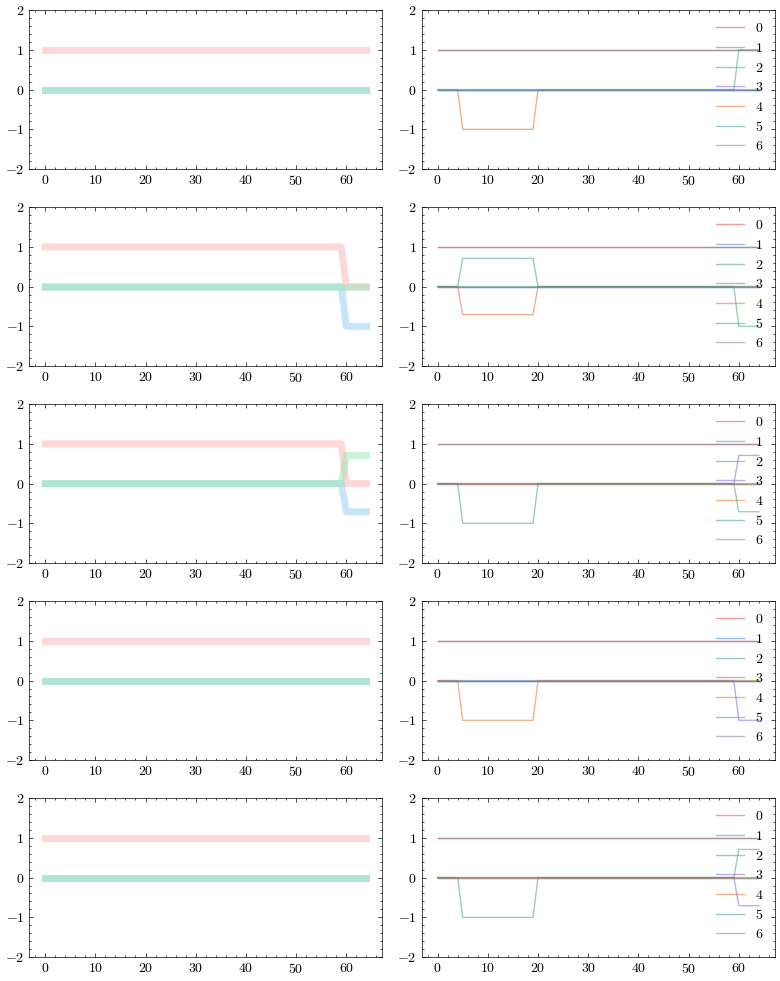

In [5]:
def plot_input_output(test_input_np, test_output_np, tag=""):
    """
    """
    test_input_np = helper.to_ndarray(test_input_np)
    # net_out = helper.to_ndarray(net_out)
    test_output_np = helper.to_ndarray(test_output_np)
    
    fig_all, axs_all = plt.subplots(5, 2, figsize=(4*2, 5*2))
    
    if test_output_np.shape[-1] == 1:
        for batch_idx, ax in enumerate(axs):
            # ax.plot(net_out[batch_idx, :, 0], color=c_vals[batch_idx])
            ax.plot(test_output_np[batch_idx, :, 0], color=c_vals_l[batch_idx])
    
    else:
        for batch_idx in range(5):
            for out_idx in range(test_output_np.shape[-1]):
                # axs_all[batch_idx,0].plot(net_out[batch_idx, :, out_idx], color=c_vals[out_idx], label=out_idx)
                axs_all[batch_idx,0].plot(test_output_np[batch_idx, :, out_idx], color=c_vals_l[out_idx], linewidth=5, alpha=0.5)
                # axs_all[batch_idx,0].set_title(f"{task_params['rules'][test_task[batch_idx]]}")
                axs_all[batch_idx,0].legend()
    
            input_batch = test_input_np[batch_idx,:,:]
            if task_params["randomize_inputs"]: 
                input_batch = input_batch @ np.linalg.pinv(task_params["randomize_matrix"])
            for inp_idx in range(input_batch.shape[-1]):
                axs_all[batch_idx,1].plot(input_batch[:,inp_idx], color=c_vals[inp_idx], label=inp_idx, alpha=0.5)
                # axs_all[batch_idx,1].set_title(f"{task_params['rules'][test_task[batch_idx]]}")
                axs_all[batch_idx,1].legend()

    for ax in axs_all.flatten(): 
        ax.set_ylim([-2, 2])
    fig_all.tight_layout()
    # fig_all.savefig(f"./twotasks/lowD_{hyp_dict['ruleset']}_{hyp_dict['chosen_network']}_seed{seed}_{hyp_dict['addon_name']}_{tag}.png", dpi=300)

plot_input_output(test_input, test_output, tag="")